In [13]:
from numpy.random import seed
seed(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from analysis import *
from collections import namedtuple
import Metrics
from PatientSet import *
from Constants import Constants
from Clustering import *
import re

#sklearn dependencies
from sklearn.metrics import roc_auc_score, adjusted_rand_score
from sklearn.utils import resample
from sklearn.cluster import FeatureAgglomeration

#we get like a million deprication errors for some reason with the external libraries
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [14]:
#plotting parameter
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24
FIG_SIZE = (20,15)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=FIG_SIZE)
db = load_patientset()

In [116]:
feature_file = 'data/clustering_results/metaClusteringBootstrapped500MinmaxBest.csv'
n_samples = 500
n_clusters = 'Best'
selection_clusterer  = BestClusterer()
save_root = 'data/sensitivity_analysis/'

In [102]:
#load in the selected features from the clustering notebook
selected_features = pd.read_csv(feature_file,index_col=0)
cluster_labels = selected_features.cluster_labels
selected_features = selected_features.drop('cluster_labels', axis = 1)
selected_features.head(5)

,Extended_Oral_Cavity_tsimdoses,Mandible_tsimdoses,t_volumes_0,Mandible_tumor_distances,Medial_Pterygoid_M_tsimdoses_combined,MPC_tumor_distances
Dummy.ID,,,,,,
3,-0.539868,-0.456024,-0.582217,1.185070,-0.124849,0.611596
4,-0.839970,-0.679145,-0.710380,0.110453,-0.802765,0.400926
10,-0.046562,-0.332554,0.224269,0.427687,-0.157904,-1.019685
11,-1.256159,-1.164121,-0.926068,-1.155143,-1.394658,-1.334111
27,-0.600296,-0.757925,-0.751016,-1.155143,-0.962031,-1.334111


In [103]:
def get_scores(scorer):
    scores = {f: [] for f in selected_features.columns}
    scores['baseline'] = []
    for n in range(n_samples):
        if n_samples > 1:
            xtemp, ytemp = resample(selected_features, db.toxicity)
        else:
            xtemp, ytemp = selected_features, db.toxicity
        base_score = scorer.bootstrap_score(xtemp, ytemp).mean()
        scores['baseline'].append(base_score)
        for feature in  selected_features.columns:
            xtemp = selected_features.drop(feature, axis = 1)
            new_score = scorer.bootstrap_score(xtemp, db.toxicity).mean()
            scores[feature].append(base_score - new_score)
    return pd.DataFrame(scores)

def plot_scores(scores, transform = None):
    fscores = scores.drop('baseline', axis = 1)
    if transform is not None:
        fscores = fscores.apply(transform)
    yerr = fscores.std()/np.sqrt(n_samples) if n_samples > 1 else np.zeros((fscores.shape[1],))
    means = fscores.mean().values
    min_arg = np.argmin(means)
    max_arg = np.argmax(means)
    max_range = yerr.max()*1.1
    yrange = [means[min_arg] - max_range, means[max_arg] + max_range]
    (fscores.mean()).plot.bar(rot = 45, **{'ylim': yrange,'yerr': yerr})

In [104]:
clustering_scores = get_scores(FeatureClusterSelector(copy.copy(selection_clusterer)))
clustering_scores.to_csv(save_root 
              + 'cluster_feature_importances_nsamples=' 
              + str(n_samples) 
              + '_clusters='
              + str(n_clusters)
              + '.csv')
clustering_scores.describe()

,Extended_Oral_Cavity_tsimdoses,Mandible_tsimdoses,t_volumes_0,Mandible_tumor_distances,Medial_Pterygoid_M_tsimdoses_combined,MPC_tumor_distances,baseline
count,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,500.000000
mean,-1.239802e-04,-1.239594e-04,-1.239818e-04,-1.239817e-04,-1.239665e-04,-1.239811e-04,0.999876
std,2.425151e-03,2.425151e-03,2.425151e-03,2.425151e-03,2.425151e-03,2.425151e-03,0.002425
min,-5.404794e-02,-5.404792e-02,-5.404794e-02,-5.404794e-02,-5.404793e-02,-5.404794e-02,0.945952
25%,-4.451807e-08,-2.369514e-08,-4.609114e-08,-4.598737e-08,-3.079754e-08,-4.539535e-08,1.000000
50%,1.257289e-09,2.208022e-08,-3.157798e-10,-2.120107e-10,1.497782e-08,3.800148e-10,1.000000
75%,1.724393e-09,2.254733e-08,1.513239e-10,2.550930e-10,1.544493e-08,8.471185e-10,1.000000
max,1.729141e-09,2.255207e-08,1.560717e-10,2.598408e-10,1.544968e-08,8.518664e-10,1.000000


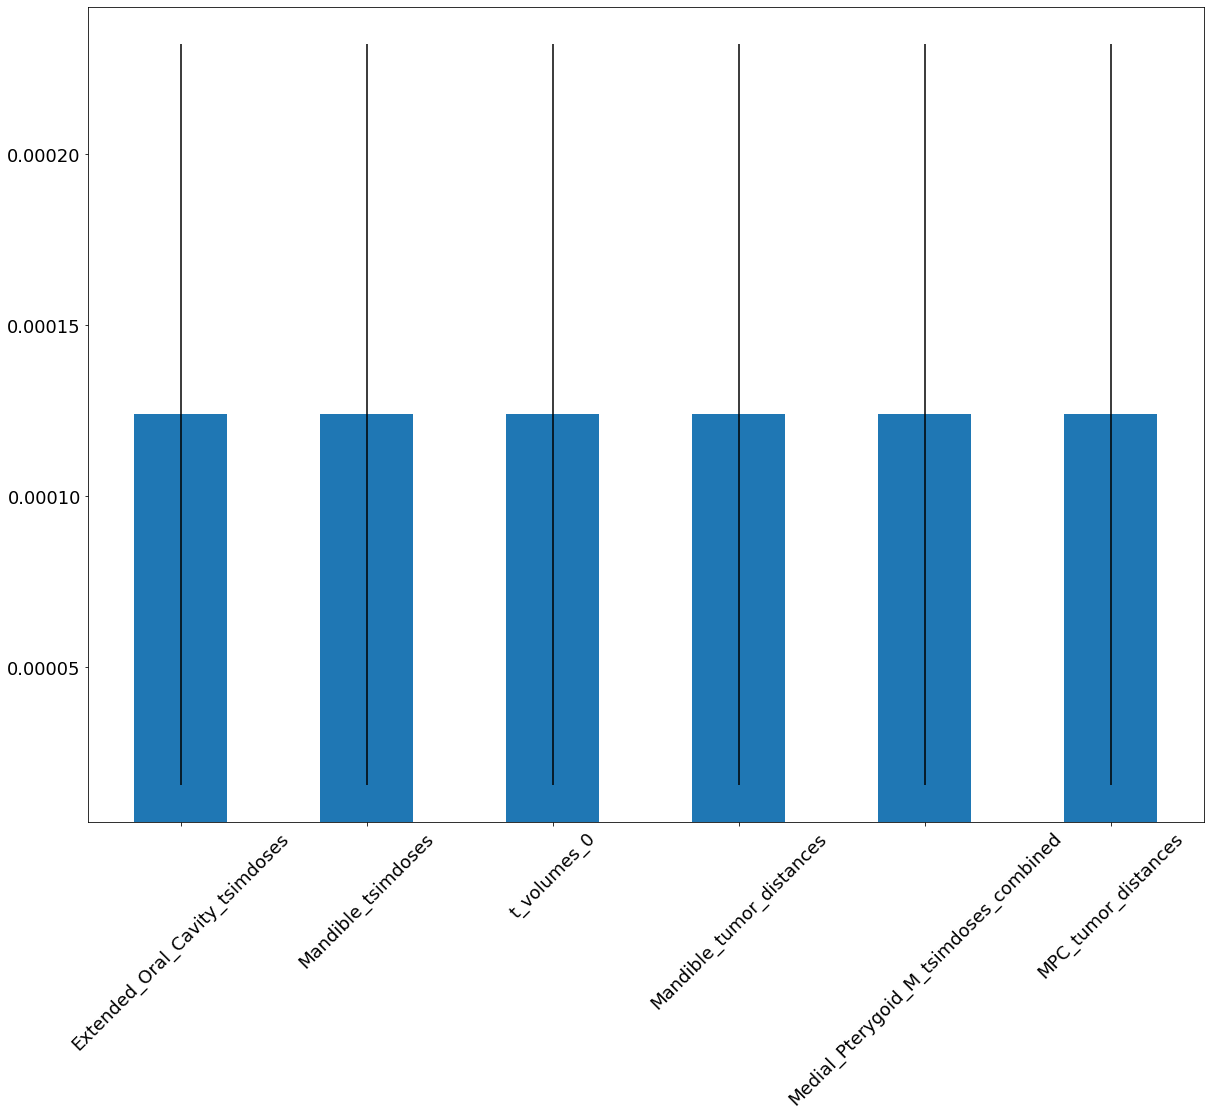

In [105]:
plot_scores(clustering_scores)

In [59]:
lg_scores = get_scores(FeatureSelector())
lg_scores.to_csv(save_root 
              + 'logistic_feature_importances_nsamples=' 
              + str(n_samples) 
              + '_clusters='
              + str(n_clusters)
              + '.csv')
lg_scores.describe()

,Extended_Oral_Cavity_tsimdoses,Mandible_tsimdoses,t_volumes_0,Mandible_tumor_distances,Medial_Pterygoid_M_tsimdoses_combined,MPC_tumor_distances,baseline
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.006004,0.008307,0.008661,0.013445,0.010610,0.010787,0.777265
std,0.056151,0.056151,0.056151,0.056151,0.056151,0.056151,0.056151
min,-0.198793,-0.196490,-0.196135,-0.191352,-0.194186,-0.194009,0.572468
25%,-0.029394,-0.027090,-0.026736,-0.021952,-0.024787,-0.024610,0.741868
50%,0.010562,0.012865,0.013220,0.018003,0.015169,0.015346,0.781823
75%,0.046186,0.048490,0.048844,0.053628,0.050793,0.050970,0.817448
max,0.157503,0.159806,0.160161,0.164944,0.162110,0.162287,0.928764


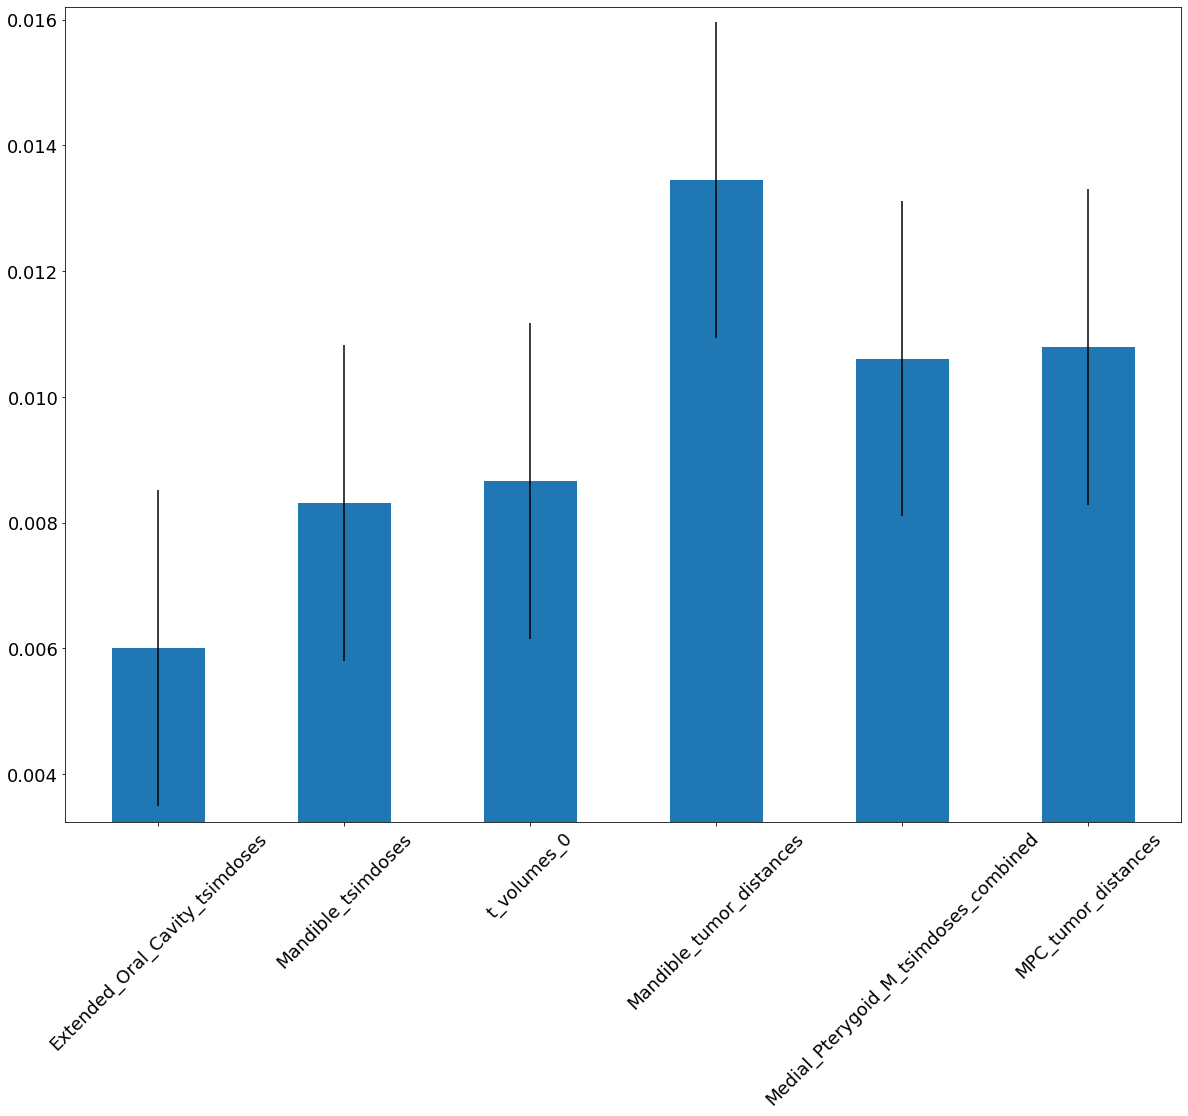

In [100]:
plot_scores(lg_scores)

In [ ]:
#this part should remove a random subset of patients (1-half the cohort size) a given number of times (currently size of the cohort times)
#then check how the new clustering behaves
pcounts = np.arange(0, int(selected_features.shape[0]-10))
n_subsamples = selected_features.shape[0]
sensitivity_report = np.zeros((n_subsamples, len(pcounts)))
feature_df = selected_features.copy()
feature_df['toxicity'] = db.toxicity
selection_clusterer = FClusterer(4, dist_func = l2)
def get_score(data_subset):
    clusters = selection_clusterer.fit_predict(data_subset.drop(['toxicity'], axis=1).values)
    return 1-fisher_exact_test(data_subset['toxicity'].values, clusters)

base_score = get_score(feature_df)
sensitivity_report[0,:] = [base_score for b in range(len(pcounts))]
for p in pcounts:
    if p == 0:
        continue
    for n in range(n_subsamples):
        data_subset = feature_df.sample(n=int(selected_features.shape[0] - p),
                                          replace = False,
                                          random_state = n)
        sensitivity_report[n, p-1] = get_score(data_subset)

In [ ]:
sensitivity_df = pd.DataFrame(sensitivity_report)
sensitivity_df.describe()

In [ ]:
sensitivity_df.to_csv(save_root 
                      + 'cohort_dropout_oneminuspval_n_subsampes=' 
                      + str(n_subsamples) 
                      + '_nfeautures='
                      + str(len(feature_df.drop(['toxicity'], axis = 1).columns))
                      + '_clusters='
                      + str(n_clusters)
                      + '.csv')

In [ ]:
mean_drop = sensitivity_report.mean(axis = 0)
drop_std = sensitivity_report.std(axis = 0)
plt.plot(pcounts, mean_drop)